🔹 Loading ViT embeddings...
✅ ViT PCs covering 90% variance: 44
🔹 Loading neural responses for VISp...
✅ VISp PCs covering 90% variance: 87
🔹 Running 5-fold image-level cross-validation...
  Fold 1: test shared var[0]=0.396
  Fold 2: test shared var[0]=0.557
  Fold 3: test shared var[0]=0.406
  Fold 4: test shared var[0]=0.416
  Fold 5: test shared var[0]=0.323


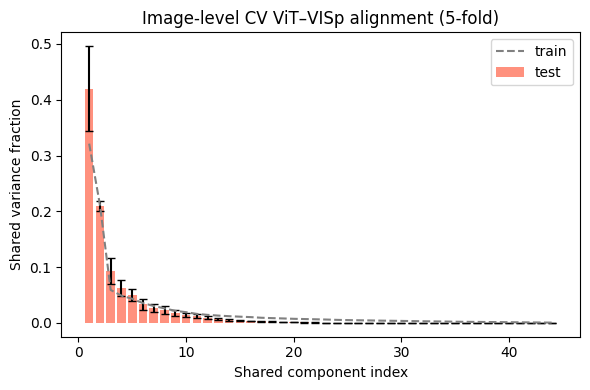

💾 Saved image-level CV results to vit_VISp_crossdomain_imageCV_results.npz


In [1]:
#!/usr/bin/env python3
"""
Image-level cross-validation of ViT–Brain shared structure.

Trains shared subspace on a subset of images, tests on held-out images.
Evaluates how well the shared latent structure generalizes across stimuli.
"""

import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.special import softmax
from skbio.stats.composition import clr
from numpy.random import default_rng

# ---------------------------------------------------------------
# CONFIG
# ---------------------------------------------------------------
VIT_PATH    = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy'
AREAS_PATH  = '/home/maria/MITNeuralComputation/visualization/brain_area.npy'
AREA_NAME   = 'VISp'

N_IMAGES, N_TRIALS = 118, 50
VAR_CUTOFF  = 0.90
N_SPLITS    = 5
RANDOM_SEED = 42
rng = default_rng(RANDOM_SEED)

# ---------------------------------------------------------------
# STEP 1: Load ViT embeddings
# ---------------------------------------------------------------
print("🔹 Loading ViT embeddings...")
with open(VIT_PATH, 'rb') as f:
    vit_logits = pickle.load(f)['natural_scenes']

Xv = softmax(np.asarray(vit_logits), axis=1)
Xv = clr(Xv + 1e-12)

vit_pca_full = PCA(random_state=RANDOM_SEED).fit(Xv)
vit_cumvar = np.cumsum(vit_pca_full.explained_variance_ratio_)
vit_ncomp = np.searchsorted(vit_cumvar, VAR_CUTOFF) + 1
vit_pca = PCA(n_components=vit_ncomp, random_state=RANDOM_SEED)
Zv = vit_pca.fit_transform(Xv)  # (images × vit_ncomp)
print(f"✅ ViT PCs covering 90% variance: {vit_ncomp}")

# ---------------------------------------------------------------
# STEP 2: Load neural data
# ---------------------------------------------------------------
print(f"🔹 Loading neural responses for {AREA_NAME}...")
dat = np.load(NEURAL_PATH, mmap_mode='r')
areas = np.load(AREAS_PATH, allow_pickle=True)
mask = (areas == AREA_NAME)
dat = dat[mask]

n_neurons, n_total = dat.shape
n_time = n_total // (N_IMAGES * N_TRIALS)
dat = dat.reshape(n_neurons, N_IMAGES, N_TRIALS, n_time)
X_mean = dat.mean(axis=(2,3))  # (neurons × images)

brain_pca_full = PCA(random_state=RANDOM_SEED).fit(X_mean.T)
brain_cumvar = np.cumsum(brain_pca_full.explained_variance_ratio_)
brain_ncomp = np.searchsorted(brain_cumvar, VAR_CUTOFF) + 1
brain_pca = PCA(n_components=brain_ncomp, random_state=RANDOM_SEED)
Zb = brain_pca.fit_transform(X_mean.T)  # (images × brain_ncomp)
print(f"✅ {AREA_NAME} PCs covering 90% variance: {brain_ncomp}")

# ---------------------------------------------------------------
# STEP 3: Image-level cross-validation
# ---------------------------------------------------------------
def crossdomain_svd(Zv, Zb):
    Zv = Zv - Zv.mean(axis=0, keepdims=True)
    Zb = Zb - Zb.mean(axis=0, keepdims=True)
    C = (Zv.T @ Zb) / Zv.shape[0]
    U, S, Vt = np.linalg.svd(C, full_matrices=False)
    shared_var = S**2 / np.sum(S**2)
    return S, shared_var

print(f"🔹 Running {N_SPLITS}-fold image-level cross-validation...")
indices = np.arange(Zv.shape[0])
rng.shuffle(indices)
folds = np.array_split(indices, N_SPLITS)

spectra_train, spectra_test = [], []

for f, test_idx in enumerate(folds):
    train_idx = np.setdiff1d(indices, test_idx)

    Zv_train, Zb_train = Zv[train_idx], Zb[train_idx]
    Zv_test,  Zb_test  = Zv[test_idx],  Zb[test_idx]

    # --- Fit shared subspace on training images ---
    S_train, shared_train = crossdomain_svd(Zv_train, Zb_train)

    # --- Evaluate shared structure on held-out test images ---
    # Project test data into learned subspace
    C_train = (Zv_train.T @ Zb_train) / len(train_idx)
    U_train, _, Vt_train = np.linalg.svd(C_train, full_matrices=False)

    Zv_proj = Zv_test @ U_train
    Zb_proj = Zb_test @ Vt_train.T

    C_test = (Zv_proj.T @ Zb_proj) / len(test_idx)
    _, S_test, _ = np.linalg.svd(C_test, full_matrices=False)
    shared_test = S_test**2 / np.sum(S_test**2)

    spectra_train.append(shared_train)
    spectra_test.append(shared_test)
    print(f"  Fold {f+1}: test shared var[0]={shared_test[0]:.3f}")

spectra_train = np.array(spectra_train)
spectra_test  = np.array(spectra_test)
mean_train = spectra_train.mean(axis=0)
mean_test  = spectra_test.mean(axis=0)
std_test   = spectra_test.std(axis=0)

# ---------------------------------------------------------------
# STEP 4: Plot
# ---------------------------------------------------------------
plt.figure(figsize=(6,4))
x = np.arange(1, len(mean_test)+1)
plt.bar(x, mean_test, yerr=std_test, color='tomato', alpha=0.7, capsize=3, label='test')
plt.plot(x, mean_train, color='gray', linestyle='--', label='train')
plt.xlabel("Shared component index")
plt.ylabel("Shared variance fraction")
plt.title(f"Image-level CV ViT–{AREA_NAME} alignment ({N_SPLITS}-fold)")
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# STEP 5: Save results
# ---------------------------------------------------------------
out = {
    "train_spectra": spectra_train,
    "test_spectra": spectra_test,
    "mean_train": mean_train,
    "mean_test": mean_test,
    "std_test": std_test,
}
np.savez(f"vit_{AREA_NAME}_crossdomain_imageCV_results.npz", **out)
print(f"💾 Saved image-level CV results to vit_{AREA_NAME}_crossdomain_imageCV_results.npz")



🔍 Visualizing shared PC1 for fold 2 (best generalization)


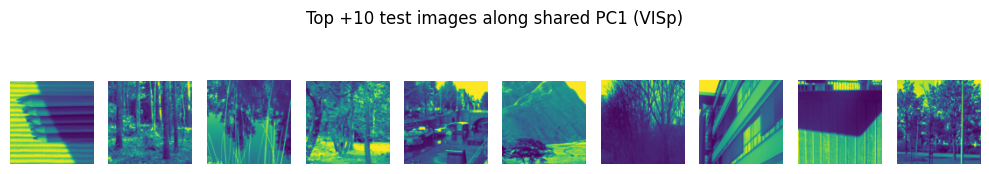

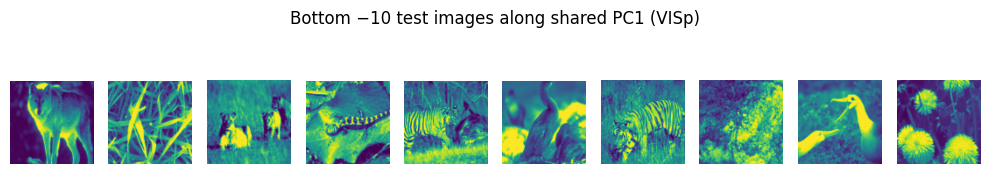

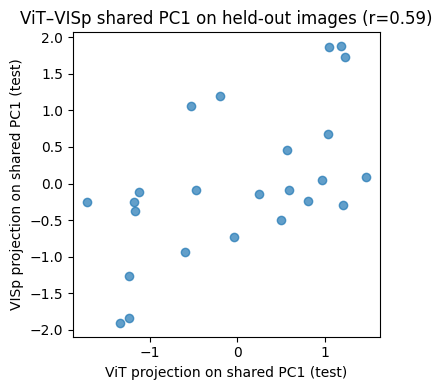

In [2]:
# ---------------------------------------------------------------
# STEP 3.5: Visualize the dominant shared component on one test fold
# ---------------------------------------------------------------
import os
from PIL import Image

IMAGES_DIR='/home/maria/MITNeuralComputation/vit_embeddings/images'

# Pick a representative fold (e.g., the one with highest test shared var[0])
best_fold = int(np.argmax([s[0] for s in spectra_test]))
test_idx = folds[best_fold]
train_idx = np.setdiff1d(indices, test_idx)
print(f"\n🔍 Visualizing shared PC1 for fold {best_fold+1} (best generalization)")

# Refit on train images for that fold
Zv_train, Zb_train = Zv[train_idx], Zb[train_idx]
Zv_test,  Zb_test  = Zv[test_idx],  Zb[test_idx]

C_train = (Zv_train.T @ Zb_train) / len(train_idx)
U_train, S_train, Vt_train = np.linalg.svd(C_train, full_matrices=False)

# Project test images into learned shared subspace
vit_shared_scores   = Zv_test @ U_train[:, 0]
brain_shared_scores = Zb_test @ Vt_train.T[:, 0]

# Normalize (optional)
vit_shared_scores   = (vit_shared_scores - vit_shared_scores.mean()) / vit_shared_scores.std()
brain_shared_scores = (brain_shared_scores - brain_shared_scores.mean()) / brain_shared_scores.std()

# Rank test images by shared axis (ViT projection)
idx_sorted = np.argsort(vit_shared_scores)
top10  = idx_sorted[-10:]
bot10  = idx_sorted[:10]

# ---------------------------------------------------------------
# Plot top/bottom test images along shared axis
# ---------------------------------------------------------------
def show_ranked_images(indices, title):
    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(indices):
        img_path = os.path.join(IMAGES_DIR, f"scene_{test_idx[idx]:03d}.png")
        img = Image.open(img_path)
        plt.subplot(1, len(indices), i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_ranked_images(top10, f"Top +10 test images along shared PC1 ({AREA_NAME})")
show_ranked_images(bot10, f"Bottom −10 test images along shared PC1 ({AREA_NAME})")

# ---------------------------------------------------------------
# Scatter plot: ViT vs Brain projections (test images only)
# ---------------------------------------------------------------
r = np.corrcoef(vit_shared_scores, brain_shared_scores)[0, 1]
plt.figure(figsize=(4, 4))
plt.scatter(vit_shared_scores, brain_shared_scores, alpha=0.7)
plt.xlabel("ViT projection on shared PC1 (test)")
plt.ylabel(f"{AREA_NAME} projection on shared PC1 (test)")
plt.title(f"ViT–{AREA_NAME} shared PC1 on held-out images (r={r:.2f})")
plt.tight_layout()
plt.show()
